In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from itertools import chain
from scipy.spatial.distance import cdist
import scipy as sp
import GPy
import safeopt
from SafeProblem import Problem

import matplotlib.pyplot as plt

def plot_function(x_1, x_2, y, safe_threshold):
    y_grid = y.reshape(len(x_1), len(x_2))
    # Plot function
    fig, ax = plt.subplots(figsize=(14, 8))
    cntr_f = ax.contourf(x_1, x_2, y_grid, levels=np.linspace(np.min(y), np.max(y), 50),
                         cmap=plt.cm.get_cmap('viridis').reversed())
    cntr_t = ax.contour(x_1, x_2, y_grid, levels=[safe_threshold], colors = "r", linewidths=2, linestyles="dashed")
    o, _ = cntr_t.legend_elements()
    legend_objs = [o[0]]
    legend_labels = ["Safety Threshold"]
    ax.legend(legend_objs, legend_labels)
    ax.set_xlabel('$x_1$'), ax.set_ylabel('$x_2$')
    ax.axis('square')
    fig.colorbar(cntr_f)
    legend = [legend_objs, legend_labels]
    return fig, ax, legend

def plot_optimal(x_opt, fig, ax, legend):
    legend[0] += ax.plot(x_opt[0], x_opt[1], 'x', color='white', markersize=10)
    legend[1] += ["Optimal"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_safeopt(opt, fig, ax, legend):
    legend[0] += ax.plot(opt.parameter_set[opt.S,0], opt.parameter_set[opt.S,1], '.',  color='grey', markersize=5)
    legend[1] += ["Safe set"]
    legend[0] += ax.plot(opt.parameter_set[opt.M,0], opt.parameter_set[opt.M,1], '.', color='m', markersize=5)
    legend[1] += ["Maximizers set"]
    legend[0] += ax.plot(opt.parameter_set[opt.G,0], opt.parameter_set[opt.G,1], '.', color='red', markersize=5,alpha=0.9)
    legend[1] += ["Expanders set"]
    legend[0] += ax.plot(opt.x[:,0], opt.x[:,1], 'x', color='blue', markersize=10)
    legend[1] += ["Evaluated points"]
    return fig, ax, legend

def plot_safe_seed(x_safe_seed, fig, ax, legend):
    o = ax.plot(x_safe_seed[:,0], x_safe_seed[:,1], 'o', markersize=5, color='k')
    legend[0] += o
    legend[1] += ["Initial safe seed"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_all(fun, opt, x_safe_seed, x_optimal):
    fig, ax, legend = plot_function(fun.x_1, fun.x_2, fun.y, opt.fmin)
    fig, ax, legend = plot_safeopt(opt, fig, ax, legend)
    fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
    plot_optimal(x_optimal, fig, ax, legend)
 
# Objective function
# WARNING: SafeOpt has issues with negative function values???
# Even if the safety threshold is positive, it will fail.
def sphere_broken(x): 
    x_opt = np.array([-1,-2])
    return -(((np.asarray(x) - x_opt)**2).sum(axis=0)) 

def sphere(x): return 100 + sphere_broken(x)

def rosenbrock(x):
    z = np.asarray(x)
    z = z + 1
    b = 100
    r = np.sum(b * (z[1:] - z[:-1]**2.0)**2.0 + (1 - z[:-1])**2.0, axis=0)
    r = 100 - np.log(r) # We take the log reduce the gradient and get a smaller lipschitz
    return r

safe_sphere = Problem(fun = sphere_broken, bounds = [(-5., 5.),(-8., 2.)], percentile = 0.75,
                     default_safe_seeds = [86225, 199784,  86241, 180581, 137070, 136068, 188095,  86672,  96619, 209639])
#safe_sphere = Problem(fun = sphere, bounds = [(-5., 5.),(-8., 2.)], percentile = 0.75,
#                     default_safe_seeds = [86225, 199784,  86241, 180581, 137070, 136068, 188095,  86672,  96619, 209639])
#safe_rosenbrok = Problem(fun = rosenbrock, bounds = [(-3., 3.),(-3.,3.)], percentile = 0.5)
fun = safe_sphere

Safe Threshold (0.75) = -7.98846992582359
Lipschitz constant = 11.979959919840175


y_opt = -0.0001285135401062649, x_opt = [-0.99198397 -2.00801603]


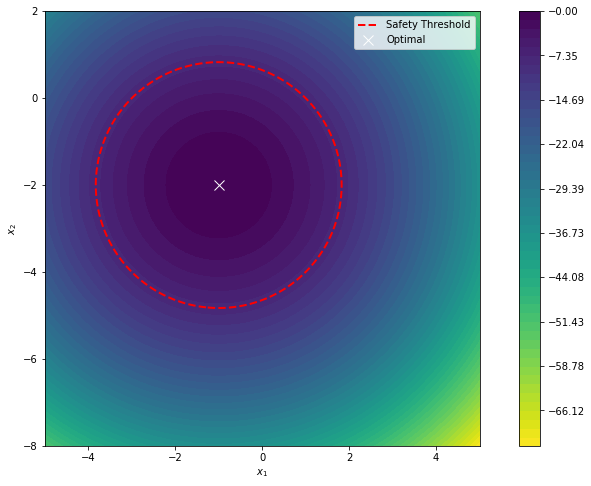

In [2]:
x_opt = fun.get_optimal_x()
y_opt = fun.get_optimal_y()
print(f'y_opt = {y_opt}, x_opt = {x_opt}')

fig, ax, legend = plot_function(fun.x_1, fun.x_2, fun.y, fun.safe_threshold)
plot_optimal(x_opt, fig, ax, legend)
plt.show()

Safe seeds:
 X = [[ 0.31062124 -4.27254509]
 [ 1.03206413 -0.28456914]
 [-0.59118236 -4.25250501]
 [-2.45490982 -0.9258517 ]
 [ 1.67334669 -2.4488978 ]
 [ 1.51302605 -2.48897796]
 [-2.21442886 -0.66533066]
 [-0.31062124 -4.23246493]
 [-2.35470942 -3.81162325]
 [-0.93186373  0.03607214]]
 y = [[-6.88218923]
 [-7.07198766]
 [-5.24091068]
 [-3.27055715]
 [-7.34829177]
 [-6.55439938]
 [-3.25617969]
 [-5.45914273]
 [-5.1172164 ]
 [-4.15023233]]
 idx = [ 93265 192801  93720 176627 138833 137825 183139  94234 104632 200703]
Safe seeds:
 X = [[-0.49098196 -4.55310621]]
 y = [[-6.77745069]]


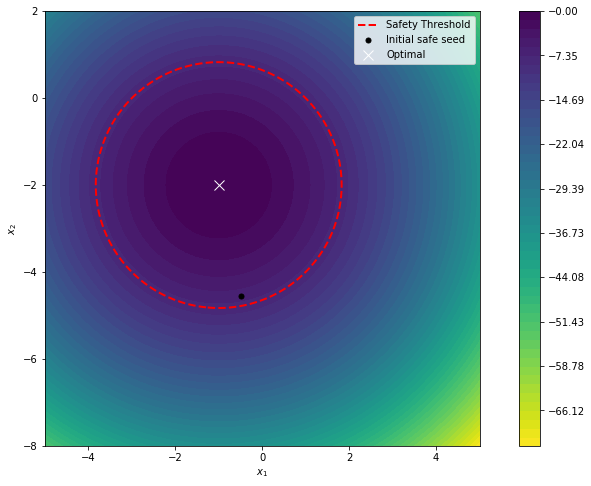

In [3]:
#Random selection (initial safe seed)
from numpy.random import default_rng
random_seed = 42
rng = default_rng(random_seed)
x_safe_seed, y_safe_seed = fun.get_uniform_safe_seeds(rng, n=10)
x_safe_seed, y_safe_seed = fun.get_default_safe_seeds(n=1)

fig, ax, legend = plot_function(fun.x_1, fun.x_2, fun.y, fun.safe_threshold)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_opt, fig, ax, legend)
plt.show()

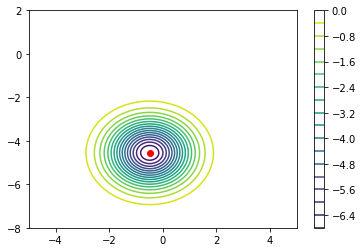

In [4]:
def run_safeopt(opt, fun, iterations, plot=False):
    for i in range(iterations):
        # Obtain next query point
        x_next = opt.optimize()
        # Get a measurement from the real system
        y_meas = fun(x_next)
        # Add this to the GP model
        opt.add_new_data_point(x_next, y_meas)
        print(f'evals={opt.t}\tx_next={x_next}\ty={y_meas}\tsafe={y_meas >= opt.fmin}')
        if plot: opt.plot(500)

def safeopt_stats(opt, fun):
    emax = opt.get_maximum()
    print(f'Estimated maximum = {emax} true_y = {fun(emax[0])}')
    print(f'Max found: {np.max(opt.y)}')
    print(f'Number of failures: {np.sum(opt.y < opt.fmin)} ({fun.n_unsafe})')
    
# Measurement noise, I will add the variance soon
noise_var = 0.00 ** 2
# Define Kernel (2-dimensional RBF kernel)
kernel = GPy.kern.RBF(input_dim=fun.xdim, ARD=True)
#kernel = GPy.kern.Matern52(fun.xdim,ARD=True)
# The statistical model of our objective function
gp = GPy.models.GPRegression(x_safe_seed, y_safe_seed, kernel, noise_var=noise_var)
# The optimization routine
# FIXME: Why beta = 1.96 ?
opt = safeopt.SafeOpt(gp, parameter_set=fun.x_matrix, fmin=fun.safe_threshold, lipschitz=fun.lipschitz, beta = 1.96, threshold=-fun.safe_threshold)
# here, use lipschitz=None for modified safeopt
#opt = safeopt.SafeOpt(gp, parameter_set=fun.x_matrix, fmin=[fun.safe_threshold], lipschitz=None, beta = 1.96)
# Plot initial safe seed
opt.plot(500)

evals=2	x_next=[ 4.57915832 -8.        ]	y=-67.12700752205815	safe=[False]
evals=3	x_next=[ 5.         -1.78757515]	y=-36.045124316769815	safe=[False]
evals=4	x_next=[-5.         -0.40480962]	y=-18.54463235087409	safe=[False]
evals=5	x_next=[0.41082164 1.97995992]	y=-17.83049867269609	safe=[False]
evals=6	x_next=[-5. -8.]	y=-52.0	safe=[False]
evals=7	x_next=[4.498998 2.      ]	y=-46.23897895992385	safe=[False]
evals=8	x_next=[-4.47895792 -4.19238477]	y=-16.90969915783471	safe=[False]
evals=9	x_next=[ 0.77154309 -8.        ]	y=-39.13836490616504	safe=[False]
evals=10	x_next=[ 1.39278557 -1.48697395]	y=-5.988618519604339	safe=[ True]
evals=11	x_next=[ 3.09619238 -4.79358717]	y=-24.582921353729507	safe=[False]


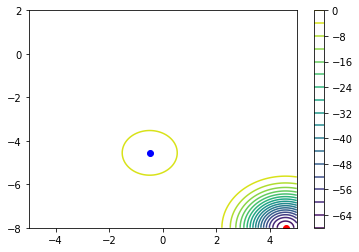

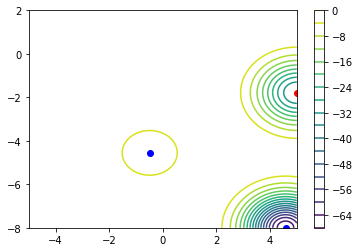

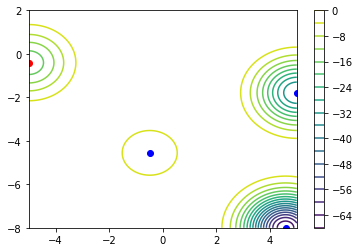

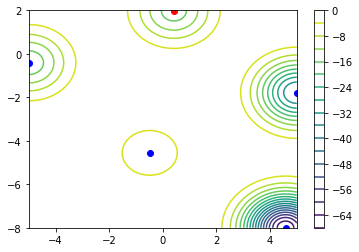

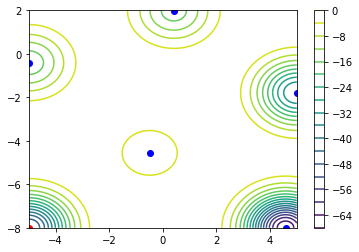

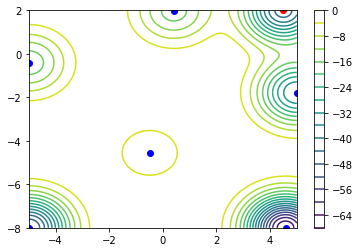

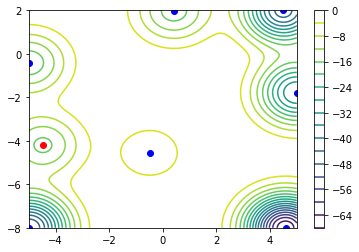

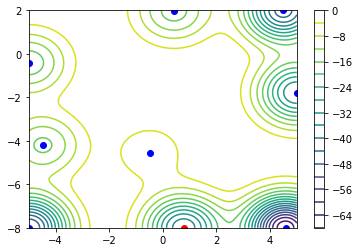

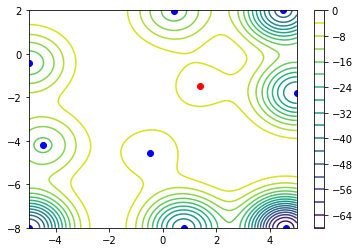

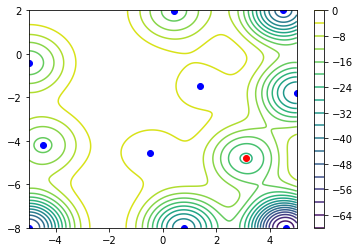

In [5]:
# do 10 iterations
run_safeopt(opt, fun, 10, plot=True)

Estimated maximum = (array([-1.69338677, -1.28657315]), -2.0923188057024884) true_y = -0.9897630933209095
Max found: -5.988618519604339
Number of failures: 9 (9)


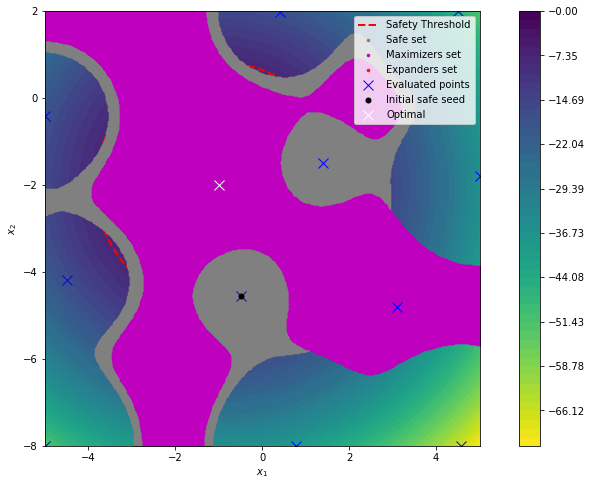

In [6]:
safeopt_stats(opt, fun)
plot_all(fun, opt, x_safe_seed, x_opt)

evals=12	x_next=[-1.89378758 -1.40681363]	y=-1.1507263023040069	safe=[ True]
evals=13	x_next=[-2.8757515  2.       ]	y=-19.518443701029312	safe=[False]
evals=14	x_next=[-2.15430862 -7.13827655]	y=-27.734314320022815	safe=[False]
evals=15	x_next=[2.45490982 0.47695391]	y=-18.07170252328303	safe=[False]
evals=16	x_next=[-5.  2.]	y=-32.0	safe=[False]
evals=17	x_next=[-2.43486974 -3.57114228]	y=-4.5273392476335435	safe=[ True]
evals=18	x_next=[-0.33066132  0.01603206]	y=-4.512399548596186	safe=[ True]
evals=19	x_next=[ 1.19238477 -3.43086172]	y=-6.8539162493323325	safe=[ True]
evals=20	x_next=[-3.51703407 -2.00801603]	y=-6.335524756928686	safe=[ True]
evals=21	x_next=[-0.43086172 -2.48897796]	y=-0.5630178192055455	safe=[ True]
evals=22	x_next=[-2.03406814 -0.1242485 ]	y=-4.587740611483489	safe=[ True]
evals=23	x_next=[-0.0501002  -1.24649299]	y=-1.470082449468073	safe=[ True]
evals=24	x_next=[-1.63326653 -2.76953908]	y=-0.9932168947112663	safe=[ True]
evals=25	x_next=[-1.03206413 -0.945891

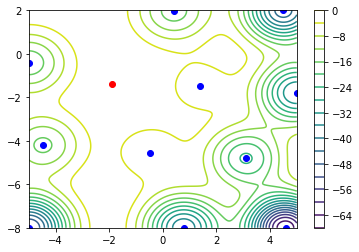

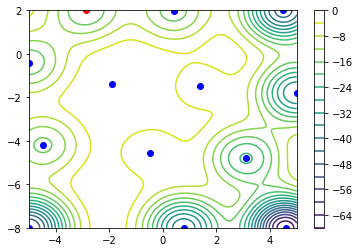

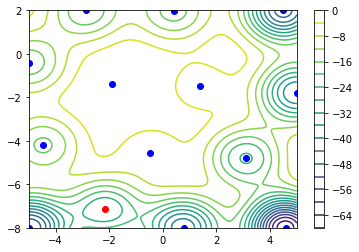

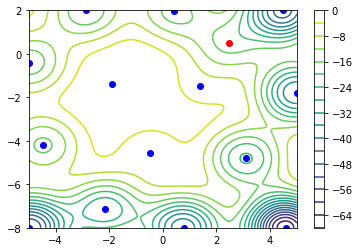

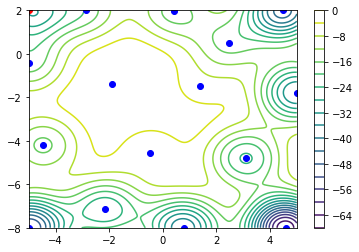

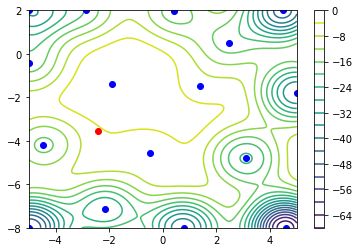

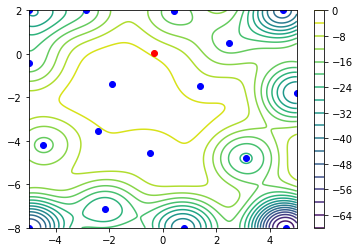

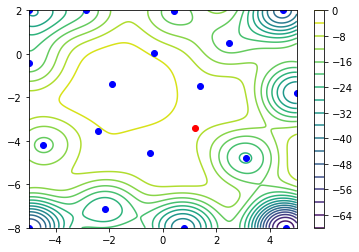

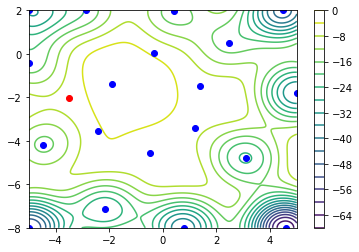

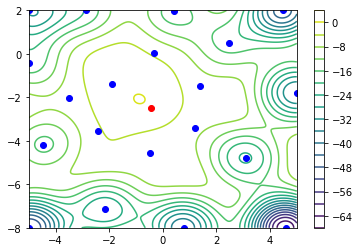

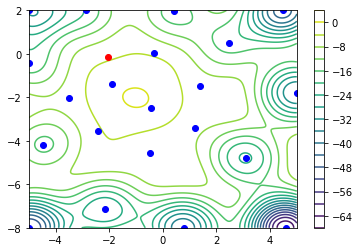

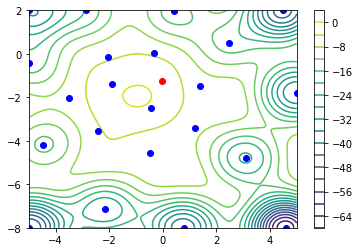

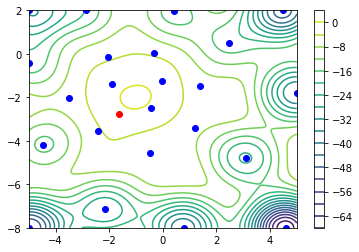

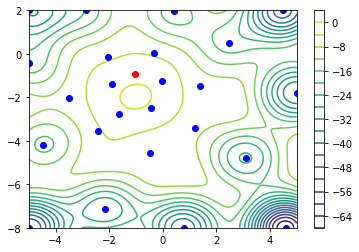

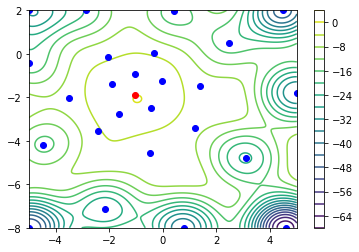

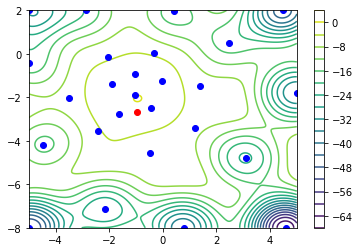

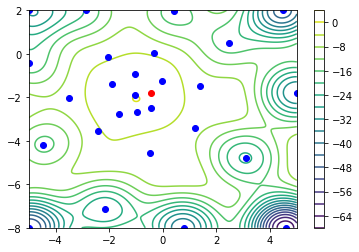

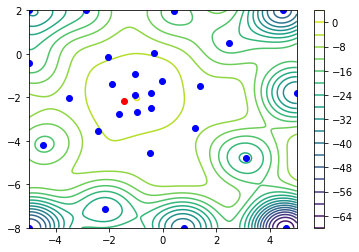

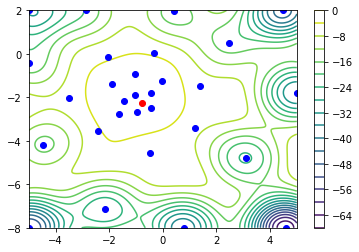

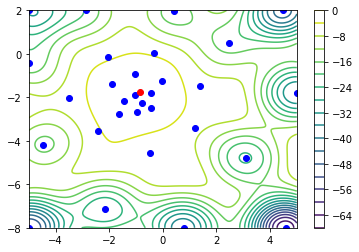

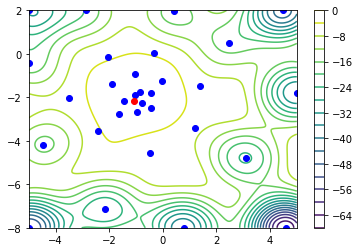

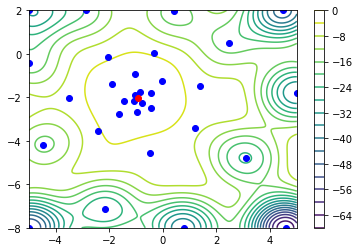

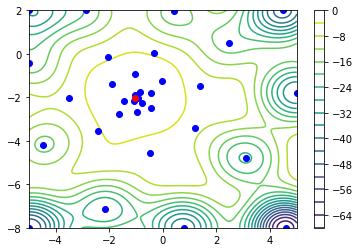

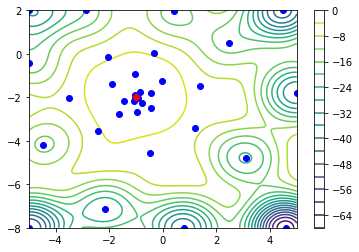

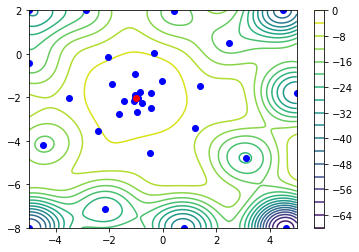

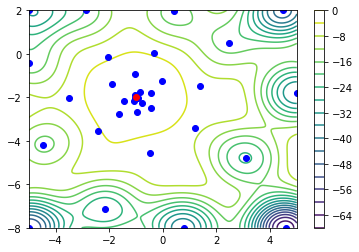

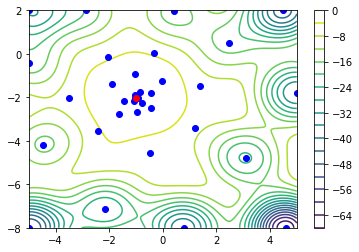

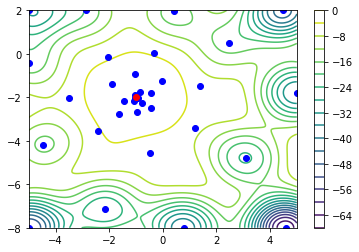

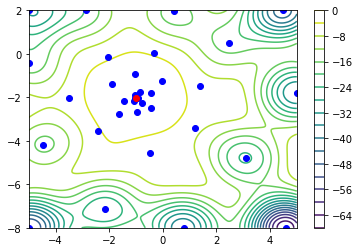

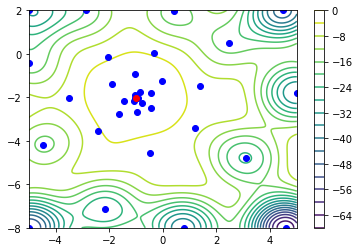

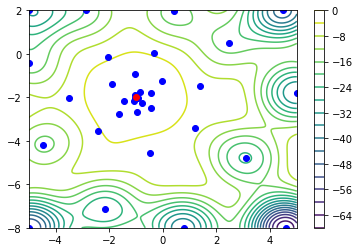

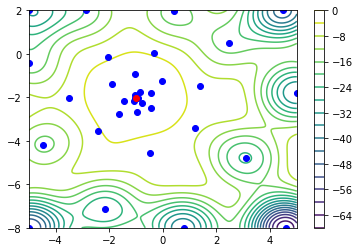

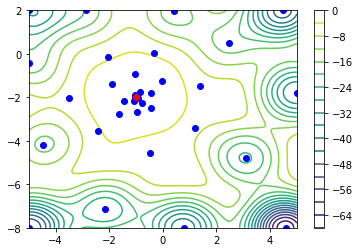

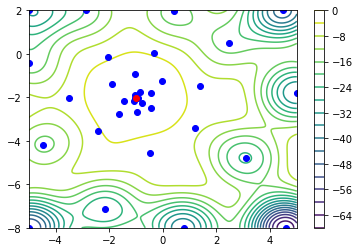

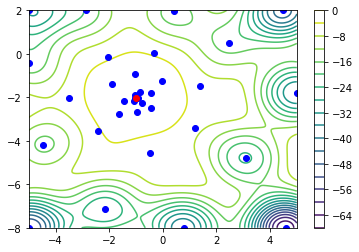

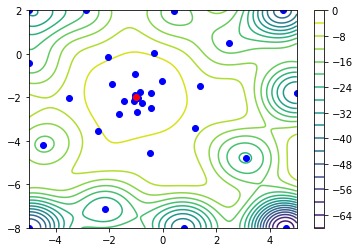

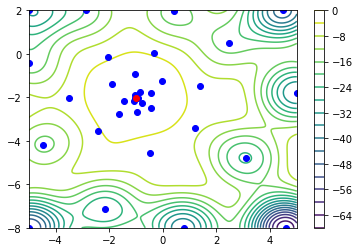

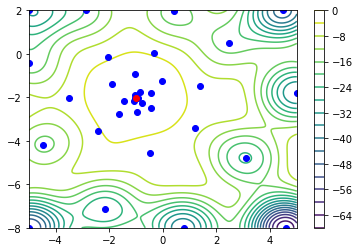

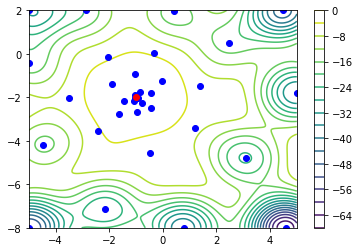

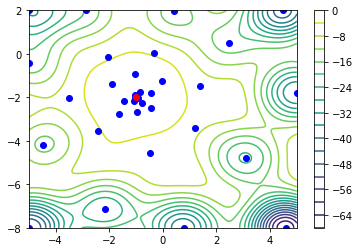

In [7]:
# do 40 more iterations (so far, 50 iterations)
run_safeopt(opt, fun, 40, plot=True)

Estimated maximum = (array([-0.99198397, -2.00801603]), -0.00021798264566129532) true_y = -0.0001285135401062649
Max found: -0.0001285135401062649
Number of failures: 13 (13)


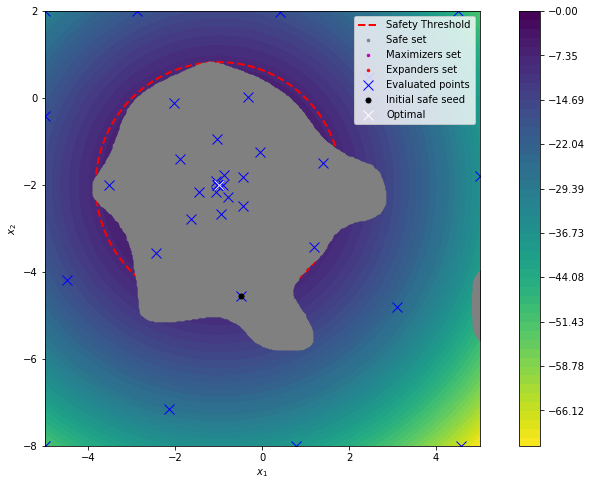

In [8]:
safeopt_stats(opt, fun)
plot_all(fun, opt, x_safe_seed, x_opt)

In [9]:
#do 60 iterations (so far 100 iterations)
run_safeopt(opt, fun, 60, plot=False) # This is very slow!

evals=52	x_next=[-1.01202405 -2.00801603]	y=-0.00020883450267269289	safe=[ True]
evals=53	x_next=[-0.99198397 -2.00801603]	y=-0.0001285135401062649	safe=[ True]
evals=54	x_next=[-1.01202405 -1.98797595]	y=-0.000289155465239096	safe=[ True]
evals=55	x_next=[-0.99198397 -1.98797595]	y=-0.00020883450267266798	safe=[ True]
evals=56	x_next=[-0.99198397 -2.00801603]	y=-0.0001285135401062649	safe=[ True]
evals=57	x_next=[-1.01202405 -2.00801603]	y=-0.00020883450267269289	safe=[ True]
evals=58	x_next=[-0.99198397 -1.98797595]	y=-0.00020883450267266798	safe=[ True]
evals=59	x_next=[-1.01202405 -2.00801603]	y=-0.00020883450267269289	safe=[ True]
evals=60	x_next=[-0.99198397 -2.00801603]	y=-0.0001285135401062649	safe=[ True]
evals=61	x_next=[-0.99198397 -1.98797595]	y=-0.00020883450267266798	safe=[ True]
evals=62	x_next=[-1.01202405 -2.00801603]	y=-0.00020883450267269289	safe=[ True]
evals=63	x_next=[-0.99198397 -1.98797595]	y=-0.00020883450267266798	safe=[ True]
evals=64	x_next=[-0.99198397 -2.0

Estimated maximum = (array([-0.99198397, -2.00801603]), -0.00017570284358783987) true_y = -0.0001285135401062649
Max found: -0.0001285135401062649
Number of failures: 13 (13)


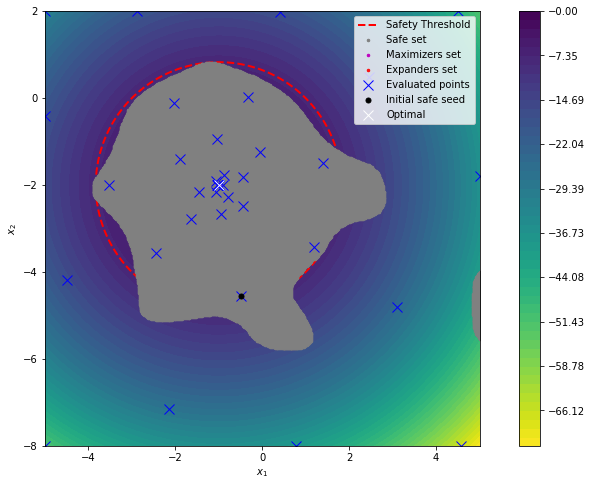

In [10]:
safeopt_stats(opt, fun)
plot_all(fun, opt, x_safe_seed, x_opt)